# Sideways Guard Backtest Lab

Backtest and compare momentum variants with optional risk overlays.

Included variants:
- Baseline
- Baseline + Profit Stop (+ cooldown)
- Hold 5
- Sideways Filter
- Hold 5 + Sideways

Notes:
- This notebook runs a close-to-close comparative simulation from `MomentumState`.
- It is intended for relative comparison across variants, not execution-grade PnL.



Generating comparison outputs for backtest...
  [ok] Baseline
  [ok] Hold 5
  [ok] Sideways Filter
  [ok] Hold 5 + Sideways


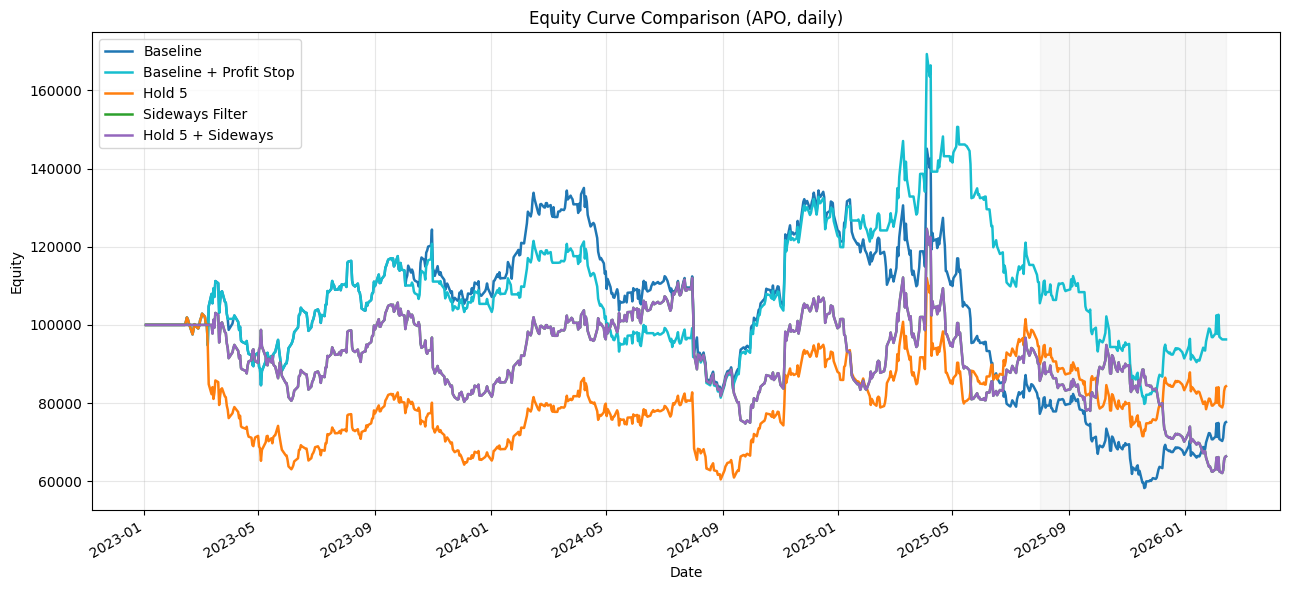

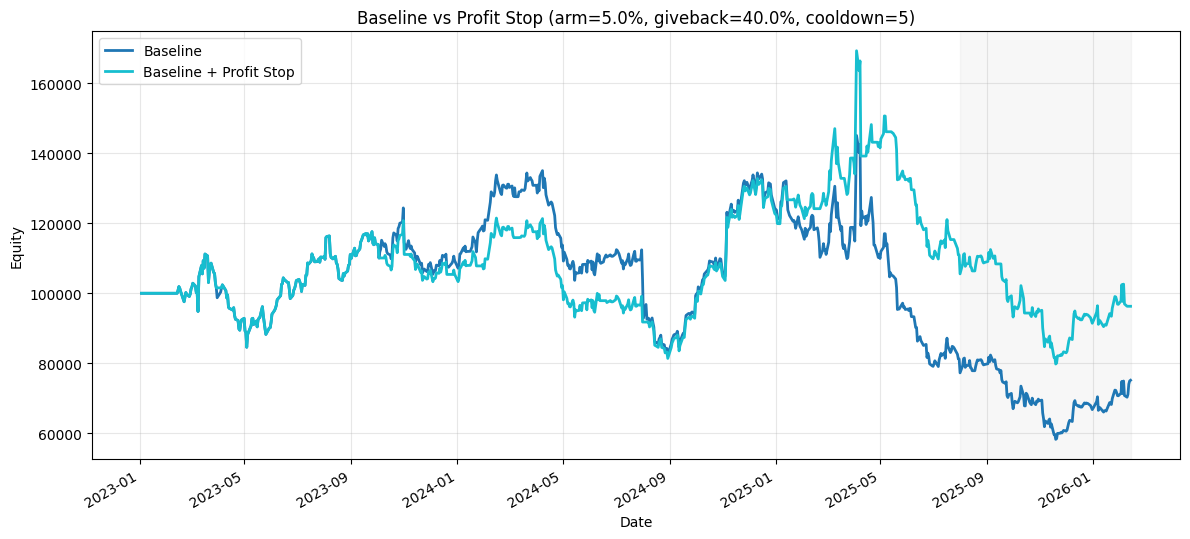

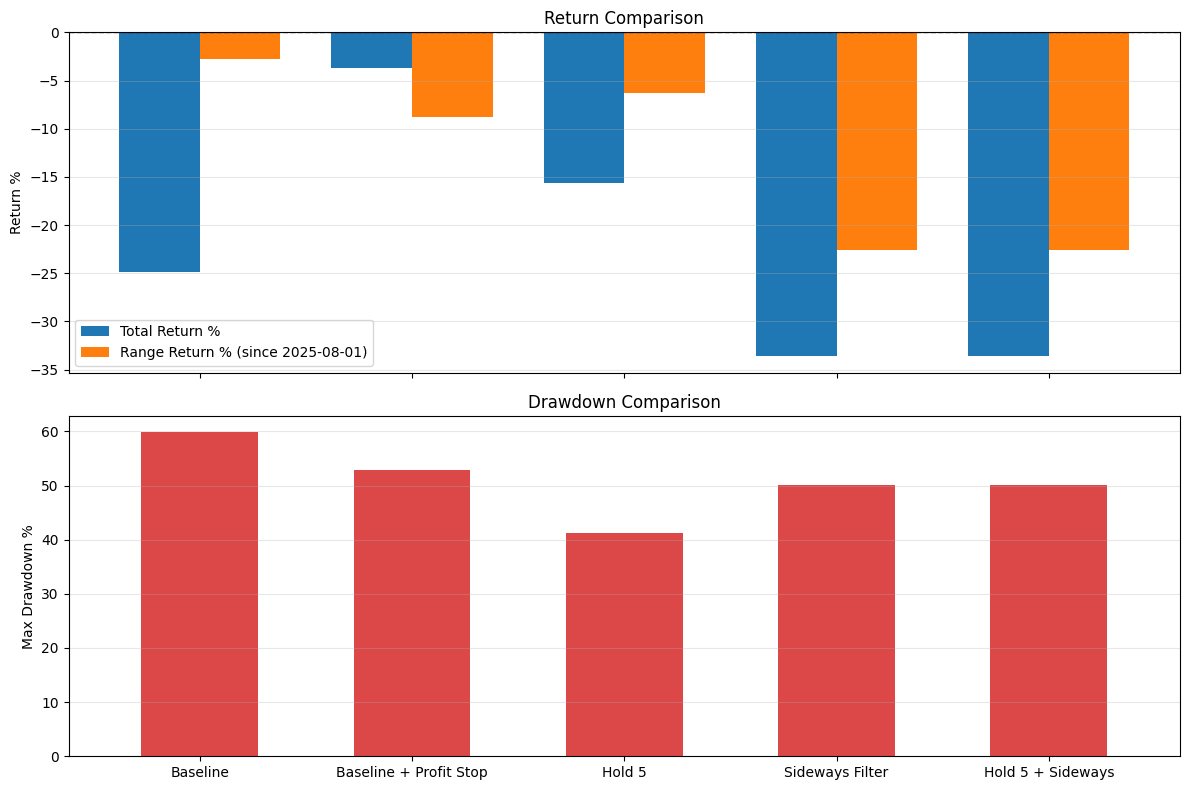


Backtest Summary
label | total_return_pct | cagr_pct | max_drawdown_pct | range_return_pct | events | reversals | profit_stop_exits
Baseline | -24.86 | -8.77 | 59.85 | -2.73 | 38 | 37 | 0
Baseline + Profit Stop | -3.72 | -1.21 | 52.88 | -8.77 | 38 | 37 | 18
Hold 5 | -15.68 | -5.33 | 41.22 | -6.25 | 22 | 21 | 0
Sideways Filter | -33.63 | -12.34 | 50.15 | -22.54 | 11 | 10 | 0
Hold 5 + Sideways | -33.63 | -12.34 | 50.15 | -22.54 | 11 | 10 | 0

Profit Stop Sweep (Baseline Source)
rank | arm_pct | giveback_pct | cooldown_bars | total_return_pct | cagr_pct | max_drawdown_pct | range_return_pct | profit_stop_exits | score
1 | 3.0 | 30.0 | 10 | 25.94 | 7.69 | 41.14 | -8.23 | 22 | 5.37
2 | 5.0 | 30.0 | 10 | 22.50 | 6.74 | 42.29 | 0.35 | 18 | 1.35
3 | 3.0 | 50.0 | 8 | 7.32 | 2.30 | 46.03 | 0.69 | 18 | -15.70
4 | 5.0 | 60.0 | 10 | 5.16 | 1.63 | 53.74 | 5.64 | 10 | -21.71
5 | 3.0 | 40.0 | 8 | 2.65 | 0.84 | 50.10 | -12.97 | 20 | -22.40
6 | 3.0 | 50.0 | 10 | -0.13 | -0.04 | 56.42 | 8.57 | 15 | -28.

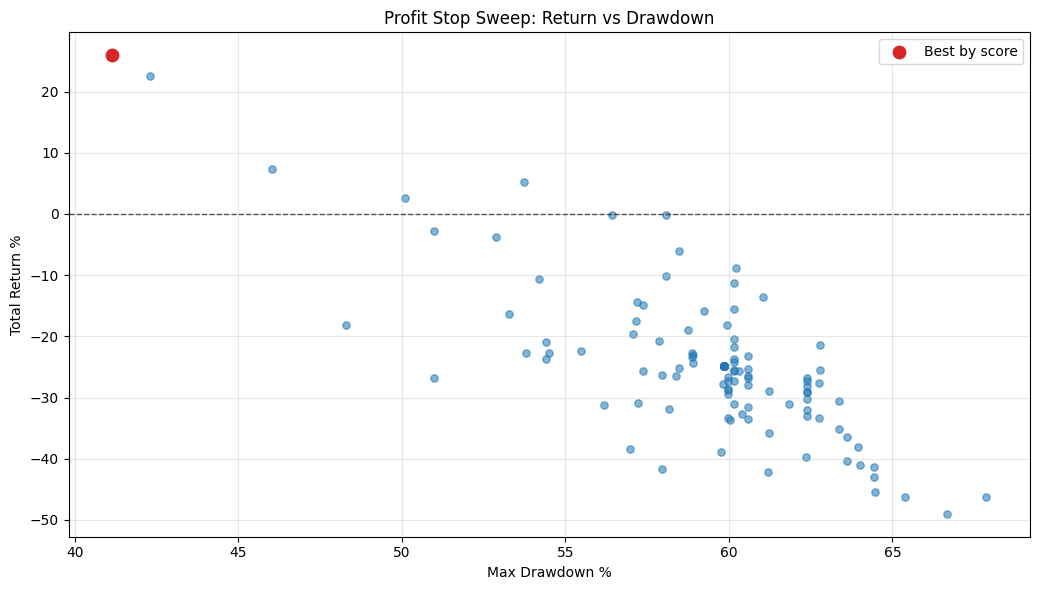

In [1]:
from pathlib import Path
import csv
from datetime import date
from itertools import product
import subprocess
import sys
import matplotlib.pyplot as plt

SYMBOL = "APO"
TIMEFRAME = "daily"  # daily | weekly | monthly
INITIAL_CAPITAL = 100000.0
RANGE_START = date.fromisoformat("2025-08-01")
RUN_STRATEGY = True  # Regenerate variant outputs before backtest

# Profit stop settings for overlay variants.
PROFIT_STOP_ARM_PCT = 5.0
PROFIT_STOP_GIVEBACK_PCT = 40.0
PROFIT_STOP_COOLDOWN_BARS = 5

# Parameter sweep (uses only rolling/current information from each bar, no future lookahead).
RUN_PROFIT_STOP_SWEEP = True
SWEEP_ARM_GRID = [3.0, 5.0, 8.0, 10.0, 12.0]
SWEEP_GIVEBACK_GRID = [20.0, 30.0, 40.0, 50.0, 60.0]
SWEEP_COOLDOWN_GRID = [0, 3, 5, 8, 10]
SWEEP_TOP_N = 12

SOURCE_CONFIGS = [
    {
        "name": "baseline",
        "label": "Baseline",
        "args": [],
        "color": "#1f77b4",
    },
    {
        "name": "hold5",
        "label": "Hold 5",
        "args": ["--min-hold-bars", "5"],
        "color": "#ff7f0e",
    },
    {
        "name": "sideways",
        "label": "Sideways Filter",
        "args": [
            "--sideways-filter",
            "--er-lookback",
            "20",
            "--min-er",
            "0.25",
            "--ema-fast",
            "10",
            "--ema-slow",
            "30",
            "--min-ema-spread-pct",
            "1.0",
        ],
        "color": "#2ca02c",
    },
    {
        "name": "combo",
        "label": "Hold 5 + Sideways",
        "args": [
            "--min-hold-bars",
            "5",
            "--sideways-filter",
            "--er-lookback",
            "20",
            "--min-er",
            "0.25",
            "--ema-fast",
            "10",
            "--ema-slow",
            "30",
            "--min-ema-spread-pct",
            "1.0",
        ],
        "color": "#9467bd",
    },
]

BACKTEST_CONFIGS = [
    {
        "name": "baseline",
        "label": "Baseline",
        "source": "baseline",
        "color": "#1f77b4",
        "profit_stop": False,
    },
    {
        "name": "baseline_profit_stop",
        "label": "Baseline + Profit Stop",
        "source": "baseline",
        "color": "#17becf",
        "profit_stop": True,
    },
    {
        "name": "hold5",
        "label": "Hold 5",
        "source": "hold5",
        "color": "#ff7f0e",
        "profit_stop": False,
    },
    {
        "name": "sideways",
        "label": "Sideways Filter",
        "source": "sideways",
        "color": "#2ca02c",
        "profit_stop": False,
    },
    {
        "name": "combo",
        "label": "Hold 5 + Sideways",
        "source": "combo",
        "color": "#9467bd",
        "profit_stop": False,
    },
]


def resolve_repo_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        if (candidate / "momentum_strategy_tv.py").exists() and (candidate / "out").exists():
            return candidate
    raise FileNotFoundError("Could not locate repo root")


def state_to_position(state: str) -> int:
    normalized = (state or "").strip().upper()
    if normalized == "LONG":
        return 1
    if normalized == "SHORT":
        return -1
    return 0


def load_rows(path: Path) -> list[dict[str, str]]:
    with path.open("r", encoding="utf-8", newline="") as handle:
        rows = list(csv.DictReader(handle))
    if not rows:
        raise ValueError(f"No rows found in {path}")
    rows.sort(key=lambda row: row["Date"])
    return rows


def compute_cagr(start_value: float, end_value: float, start_date: date, end_date: date) -> float:
    days = (end_date - start_date).days
    if days <= 0 or start_value <= 0:
        return 0.0
    years = days / 365.25
    if years <= 0:
        return 0.0
    return (end_value / start_value) ** (1.0 / years) - 1.0


def run_state_backtest(
    rows: list[dict[str, str]],
    initial_capital: float,
    use_profit_stop: bool,
    profit_arm_pct: float,
    profit_giveback_pct: float,
    profit_stop_cooldown_bars: int,
) -> dict[str, object]:
    dates = [date.fromisoformat(row["Date"]) for row in rows]
    closes = [float(row["Close"]) for row in rows]

    equity: list[float] = [initial_capital]
    daily_returns: list[float] = [0.0]

    max_equity = initial_capital
    max_drawdown = 0.0

    position = 0  # -1 short, 0 flat, 1 long
    entry_price: float | None = None
    peak_profit_pct: float = 0.0
    profit_stop_exits = 0
    cooldown_bars_remaining = 0

    first_pos = state_to_position(rows[0].get("MomentumState", "FLAT"))
    if first_pos != 0:
        position = first_pos
        entry_price = closes[0]
        peak_profit_pct = 0.0

    for idx in range(1, len(rows)):
        prev_close = closes[idx - 1]
        curr_close = closes[idx]

        # Sync toward signal state from previous bar close, unless cooldown is active.
        signal_pos = 0 if cooldown_bars_remaining > 0 else state_to_position(rows[idx - 1].get("MomentumState", "FLAT"))
        if signal_pos != position:
            if signal_pos == 0:
                position = 0
                entry_price = None
                peak_profit_pct = 0.0
            elif position == 0:
                position = signal_pos
                entry_price = prev_close
                peak_profit_pct = 0.0
            else:
                position = signal_pos
                entry_price = prev_close
                peak_profit_pct = 0.0

        ret = 0.0 if prev_close == 0 else position * ((curr_close - prev_close) / prev_close)
        new_equity = equity[-1] * (1.0 + ret)
        equity.append(new_equity)
        daily_returns.append(ret)

        if use_profit_stop and position != 0 and entry_price is not None and entry_price > 0:
            if position == 1:
                current_profit_pct = ((curr_close - entry_price) / entry_price) * 100.0
            else:
                current_profit_pct = ((entry_price - curr_close) / entry_price) * 100.0

            if current_profit_pct > peak_profit_pct:
                peak_profit_pct = current_profit_pct

            if peak_profit_pct >= profit_arm_pct:
                giveback_level = peak_profit_pct * (1.0 - (profit_giveback_pct / 100.0))
                if current_profit_pct <= giveback_level:
                    position = 0
                    entry_price = None
                    peak_profit_pct = 0.0
                    profit_stop_exits += 1
                    cooldown_bars_remaining = max(0, profit_stop_cooldown_bars)

        if cooldown_bars_remaining > 0:
            cooldown_bars_remaining -= 1

        if new_equity > max_equity:
            max_equity = new_equity
        drawdown = 0.0 if max_equity == 0 else (max_equity - new_equity) / max_equity
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    start_date = dates[0]
    end_date = dates[-1]
    total_return = (equity[-1] / initial_capital) - 1.0
    cagr = compute_cagr(initial_capital, equity[-1], start_date, end_date)

    range_start_idx = next((idx for idx, d in enumerate(dates) if d >= RANGE_START), None)
    if range_start_idx is None:
        range_return = 0.0
    else:
        start_eq = equity[range_start_idx]
        end_eq = equity[-1]
        range_return = 0.0 if start_eq == 0 else (end_eq / start_eq) - 1.0

    events = [row for row in rows if (row.get("MomentumEvent") or "").strip()]
    reversals = [row for row in events if row["MomentumEvent"] in {"LONG_TO_SHORT", "SHORT_TO_LONG"}]

    return {
        "dates": dates,
        "equity": equity,
        "total_return": total_return,
        "cagr": cagr,
        "max_drawdown": max_drawdown,
        "range_return": range_return,
        "events": len(events),
        "reversals": len(reversals),
        "profit_stop_exits": profit_stop_exits,
    }


repo_root = resolve_repo_root()
out_root = repo_root / "out"
script_path = repo_root / "momentum_strategy_tv.py"

if RUN_STRATEGY:
    print("Generating comparison outputs for backtest...")
    for cfg in SOURCE_CONFIGS:
        out_dir = out_root / f"momentum_tv_cmp_{cfg['name']}"
        latest_file = out_root / f"momentum_tv_cmp_{cfg['name']}_latest.csv"
        errors_file = out_root / f"momentum_tv_cmp_{cfg['name']}_errors.csv"

        cmd = [
            sys.executable,
            str(script_path),
            "--timeframe",
            TIMEFRAME,
            "--out-dir",
            str(out_dir),
            "--latest-file",
            str(latest_file),
            "--errors-file",
            str(errors_file),
        ] + cfg["args"]

        proc = subprocess.run(cmd, cwd=repo_root, capture_output=True, text=True)
        if proc.returncode != 0:
            print(proc.stdout)
            print(proc.stderr)
            raise RuntimeError(f"Run failed for {cfg['label']}")
        print(f"  [ok] {cfg['label']}")

rows_by_source: dict[str, list[dict[str, str]]] = {}
for cfg in SOURCE_CONFIGS:
    csv_path = out_root / f"momentum_tv_cmp_{cfg['name']}" / f"{SYMBOL}.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing {csv_path}")
    rows_by_source[cfg["name"]] = load_rows(csv_path)

results: dict[str, dict[str, object]] = {}
for cfg in BACKTEST_CONFIGS:
    rows = rows_by_source[cfg["source"]]
    results[cfg["name"]] = run_state_backtest(
        rows,
        initial_capital=INITIAL_CAPITAL,
        use_profit_stop=cfg["profit_stop"],
        profit_arm_pct=PROFIT_STOP_ARM_PCT,
        profit_giveback_pct=PROFIT_STOP_GIVEBACK_PCT,
        profit_stop_cooldown_bars=PROFIT_STOP_COOLDOWN_BARS,
    )

fig, ax = plt.subplots(figsize=(13, 6))
for cfg in BACKTEST_CONFIGS:
    result = results[cfg["name"]]
    ax.plot(result["dates"], result["equity"], label=cfg["label"], linewidth=1.8, color=cfg["color"])

ax.axvspan(RANGE_START, results[BACKTEST_CONFIGS[0]["name"]]["dates"][-1], color="#999999", alpha=0.08)
ax.set_title(f"Equity Curve Comparison ({SYMBOL}, {TIMEFRAME})")
ax.set_xlabel("Date")
ax.set_ylabel("Equity")
ax.grid(alpha=0.3)
ax.legend(loc="best")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

fig_focus, ax_focus = plt.subplots(figsize=(12, 5.5))
for cfg_name in ["baseline", "baseline_profit_stop"]:
    cfg = next(item for item in BACKTEST_CONFIGS if item["name"] == cfg_name)
    result = results[cfg_name]
    ax_focus.plot(result["dates"], result["equity"], label=cfg["label"], linewidth=2.0, color=cfg["color"])
ax_focus.axvspan(RANGE_START, results["baseline"]["dates"][-1], color="#999999", alpha=0.08)
ax_focus.set_title(
    f"Baseline vs Profit Stop (arm={PROFIT_STOP_ARM_PCT}%, giveback={PROFIT_STOP_GIVEBACK_PCT}%, cooldown={PROFIT_STOP_COOLDOWN_BARS})"
)
ax_focus.set_xlabel("Date")
ax_focus.set_ylabel("Equity")
ax_focus.grid(alpha=0.3)
ax_focus.legend(loc="best")
fig_focus.autofmt_xdate()
plt.tight_layout()
plt.show()

labels = [cfg["label"] for cfg in BACKTEST_CONFIGS]
total_returns = [results[cfg["name"]]["total_return"] * 100.0 for cfg in BACKTEST_CONFIGS]
range_returns = [results[cfg["name"]]["range_return"] * 100.0 for cfg in BACKTEST_CONFIGS]
max_dd = [results[cfg["name"]]["max_drawdown"] * 100.0 for cfg in BACKTEST_CONFIGS]

fig2, (ax_ret, ax_dd) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
x = list(range(len(labels)))
bar_w = 0.38

ax_ret.bar([p - bar_w / 2 for p in x], total_returns, width=bar_w, label="Total Return %", color="#1f77b4")
ax_ret.bar([p + bar_w / 2 for p in x], range_returns, width=bar_w, label=f"Range Return % (since {RANGE_START})", color="#ff7f0e")
ax_ret.axhline(0.0, color="#111111", linewidth=1.0, linestyle="--", alpha=0.7)
ax_ret.set_ylabel("Return %")
ax_ret.set_title("Return Comparison")
ax_ret.grid(axis="y", alpha=0.3)
ax_ret.legend(loc="best")

ax_dd.bar(x, max_dd, width=0.55, color="#d62728", alpha=0.85)
ax_dd.set_xticks(x)
ax_dd.set_xticklabels(labels)
ax_dd.set_ylabel("Max Drawdown %")
ax_dd.set_title("Drawdown Comparison")
ax_dd.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBacktest Summary")
print("label | total_return_pct | cagr_pct | max_drawdown_pct | range_return_pct | events | reversals | profit_stop_exits")
for cfg in BACKTEST_CONFIGS:
    r = results[cfg["name"]]
    print(
        f"{cfg['label']} | {r['total_return'] * 100.0:.2f} | {r['cagr'] * 100.0:.2f} | "
        f"{r['max_drawdown'] * 100.0:.2f} | {r['range_return'] * 100.0:.2f} | "
        f"{r['events']} | {r['reversals']} | {r['profit_stop_exits']}"
    )

if RUN_PROFIT_STOP_SWEEP:
    baseline_rows = rows_by_source["baseline"]
    sweep_results: list[dict[str, float | int]] = []

    for arm_pct, giveback_pct, cooldown_bars in product(
        SWEEP_ARM_GRID,
        SWEEP_GIVEBACK_GRID,
        SWEEP_COOLDOWN_GRID,
    ):
        sweep_bt = run_state_backtest(
            baseline_rows,
            initial_capital=INITIAL_CAPITAL,
            use_profit_stop=True,
            profit_arm_pct=arm_pct,
            profit_giveback_pct=giveback_pct,
            profit_stop_cooldown_bars=int(cooldown_bars),
        )
        total_return_pct = sweep_bt["total_return"] * 100.0
        max_drawdown_pct = sweep_bt["max_drawdown"] * 100.0
        score = total_return_pct - (0.50 * max_drawdown_pct)
        sweep_results.append(
            {
                "arm_pct": float(arm_pct),
                "giveback_pct": float(giveback_pct),
                "cooldown_bars": int(cooldown_bars),
                "total_return_pct": total_return_pct,
                "cagr_pct": sweep_bt["cagr"] * 100.0,
                "max_drawdown_pct": max_drawdown_pct,
                "range_return_pct": sweep_bt["range_return"] * 100.0,
                "profit_stop_exits": int(sweep_bt["profit_stop_exits"]),
                "score": score,
            }
        )

    sweep_results.sort(key=lambda row: row["score"], reverse=True)

    print("\nProfit Stop Sweep (Baseline Source)")
    print("rank | arm_pct | giveback_pct | cooldown_bars | total_return_pct | cagr_pct | max_drawdown_pct | range_return_pct | profit_stop_exits | score")
    for idx, row in enumerate(sweep_results[:SWEEP_TOP_N], start=1):
        print(
            f"{idx} | {row['arm_pct']:.1f} | {row['giveback_pct']:.1f} | {row['cooldown_bars']} | "
            f"{row['total_return_pct']:.2f} | {row['cagr_pct']:.2f} | {row['max_drawdown_pct']:.2f} | "
            f"{row['range_return_pct']:.2f} | {row['profit_stop_exits']} | {row['score']:.2f}"
        )

    best = sweep_results[0]
    print(
        "\nBest-by-score setting: "
        f"arm={best['arm_pct']:.1f}%, giveback={best['giveback_pct']:.1f}%, cooldown={best['cooldown_bars']}"
    )

    fig3, ax3 = plt.subplots(figsize=(10.5, 6))
    x_dd = [row["max_drawdown_pct"] for row in sweep_results]
    y_ret = [row["total_return_pct"] for row in sweep_results]
    ax3.scatter(x_dd, y_ret, alpha=0.55, color="#1f77b4", s=28)
    ax3.scatter([best["max_drawdown_pct"]], [best["total_return_pct"]], color="#d62728", s=80, label="Best by score")
    ax3.axhline(0.0, color="#111111", linewidth=1.0, linestyle="--", alpha=0.7)
    ax3.set_xlabel("Max Drawdown %")
    ax3.set_ylabel("Total Return %")
    ax3.set_title("Profit Stop Sweep: Return vs Drawdown")
    ax3.grid(alpha=0.3)
    ax3.legend(loc="best")
    plt.tight_layout()
    plt.show()

